# TUnfoldDensity example with pyroot

In [1]:
import ROOT
import numpy as np
import array as array
import math
ROOT.gStyle.SetOptStat(000000)

Welcome to JupyROOT 6.10/04


## Construct the Binning scheme

Set the axis ranges for the generator (m bins) and detector  (n bins) level distributions as well as the number of bins in each. *Note* that we are currently using twice as many detector bins as generator level bins as recommended by the TUnfold documenation. This condition $n ≥ m$ 
is in contrast to many common unfoldding algorithms which require $n = m$ however a notable example of an unfolding algorithm without that restriction is __[G. D’Agostini](arXiv:1010.0632)__.

In [2]:
### Set up the binning scheme
mbinsGen  = array.array('d',  [0., 50., 100. ])
mbinsDet  = array.array('d', [0., 25.,50.,75.,100. ])
ptbinsGen = array.array('d', [0., 50., 100. ])
ptbinsDet = array.array('d', [0., 50., 100. ])

#mbinsGen  = array.array('d', [0., 25.,50.,75.,100. ])# [0., 50., 100. ])
#mbinsDet  = array.array('d', [0., 12.5, 25.,37.5,50., 62.5,75., 87.5, 100. ])#[0., 25.,50.,75.,100. ])
#ptbinsGen = array.array('d', [0., 25.,50.,75.,100. ])#[0., 50., 100. ])
#ptbinsDet = array.array('d', [0., 25.,50.,75.,100. ])#[0., 50., 100. ])


nmbinsGen  = len(mbinsGen) -1
nmbinsDet  = len(mbinsDet) -1
nptbinsGen = len(ptbinsGen) -1
nptbinsDet = len(ptbinsDet) -1

print "There are {} Gen Mass bins , {} Gen Pt bins ,{} Reco Mass bins , {} Reco Pt bins  ".format(nmbinsGen,nptbinsGen , nmbinsDet,nptbinsDet)

There are 2 Gen Mass bins , 2 Gen Pt bins ,4 Reco Mass bins , 2 Reco Pt bins  


Instantiate the TUnfoldBinning Scheme. The "signal" node represents the generator level (coarser) binning whereas the "detector" node represents the (finer) input binning scheme. 

In [3]:
generatorBinning = ROOT.TUnfoldBinning("generator")
### Need coarser binning for signal
signalBinning = generatorBinning.AddBinning("signal")    
signalBinning.AddAxis("massgen",nmbinsGen,mbinsGen,
                        True, # needed for fakes
                        True # overflow bin
                        )
signalBinning.AddAxis("ptgen",nptbinsGen,ptbinsGen,
                        True, # needed for fakes
                        True # overflow bin
                        )

# X axis : generator binning is Signal : mgen * ptgen and Background : mrec * ptrec

xaxis =  array.array('d',[a for a in xrange(nmbinsGen *nptbinsGen + 1 )])
nx = len(xaxis)-1

print xaxis
print "There are {} (signal) generator level bins in the simple scheme".format(nx)
print "---------------------------------------------------------------"

print "signalBinning"
for i in xrange(len(signalBinning.GetDistributionBinning(0))):
    print  signalBinning.GetDistributionBinning(0)[i]

#print "detectorBinning"
#for i in xrange(len(backgroundBinning.GetDistributionBinning(0))):
#    print backgroundBinning.GetDistributionBinning(0)[i]
    
#print "Below counts include overflow and underflow bins"    
#print "There are {} signal {} background bins in the generator scheme".format(signalBinning.GetTH1xNumberOfBins() , backgroundBinning.GetDistributionNumberOfBins())
genBin = generatorBinning

array('d', [0.0, 1.0, 2.0, 3.0, 4.0])
There are 4 (signal) generator level bins in the simple scheme
---------------------------------------------------------------
signalBinning
0.0
50.0
100.0


In [4]:
detectorBinning = ROOT.TUnfoldBinning("detector") 
detectorDistribution=detectorBinning.AddBinning("detectordistribution")
detectorDistribution.AddAxis("mass",nmbinsDet,mbinsDet,
                        False, # no underflow bin (not reconstructed)
                        True # overflow bin
                        )
detectorDistribution.AddAxis("pt",nptbinsDet,ptbinsDet,
                        False, # no underflow bin (not reconstructed)
                        True # overflow bin
                        )

yaxis =  array.array('d',[a for a in xrange(nmbinsDet *nptbinsDet+1 )])
ny = len(yaxis)-1

print yaxis
print "There are {}  detector level bins in the simple scheme".format(ny)
print "detectorBinning"
for i in xrange(len(detectorDistribution.GetDistributionBinning(0))):
    print detectorDistribution.GetDistributionBinning(0)[i]
    
print "Below counts include overflow and underflow bins"  
print "There are {} bins in the detector scheme".format(detectorDistribution.GetTH1xNumberOfBins())#GetDistributionNumberOfBins())
detBin  = detectorBinning

array('d', [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
There are 8  detector level bins in the simple scheme
detectorBinning
0.0
25.0
50.0
75.0
100.0
Below counts include overflow and underflow bins
There are 15 bins in the detector scheme


# Create Response Matrix and 1D input 

In [5]:


M = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generatorBinning,detectorBinning,"M")
M1 = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generatorBinning,detectorBinning,"M+1#sigma")
M2 = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generatorBinning,detectorBinning,"M-1#sigma")

h = detectorBinning.CreateHistogram("h")

hup = detectorBinning.CreateHistogram("hup")
hdn = detectorBinning.CreateHistogram("hdn")
hup.SetLineStyle(2)
hdn.SetLineStyle(3)


htrue = generatorBinning.CreateHistogram("htrue")
htruef = detectorBinning.CreateHistogram("htruef")



/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: creating converter for unknown type "int**"
  import sys


## Generate the response matrix

Here, we have a respone matrix with 4 coarse and 8 fine bins (configurable). The variable of interest ($x$) ranges from 0 to 100. We assume the resolution on $x$ is 1.0, and that there is a systematic uncertainty "scale", which has an "up" and "down" variation of 2%. We generate 10000 pseudo-events for each value of x between 0 and 100, smeared by the resolution. For each of the "x" values, a reconstructed "y" value is constructed, again smeared by the resolution. We then add the "up" and "down" scale uncertainites. Finally, we construct TH2 matrices that represent the response matrices. 

In [6]:


nev = 100000
xavg = 110.
yavg = 110.
xres = 1.
yres = 1.
gen2x = np.random.random(nev) * xavg
reco2x = np.random.randn(nev) * xres + gen2x
gen2y = np.random.random(nev) * yavg
reco2y = np.random.randn(nev) * yres + gen2y

scaleup = 1.1
scaledn = 0.9

gen2yu = np.random.random(nev) * yavg*scaleup
reco2yu = np.random.randn(nev) * yres + gen2yu


gen2yd = np.random.random(nev) * yavg*scaledn
reco2yd = np.random.randn(nev) * yres + gen2yd


gen2 = np.array( [gen2x,gen2y] ).T
reco2 = np.array( [reco2x,reco2y] ).T
r = np.array( [gen2x, gen2y, reco2x, reco2y] ).T

ru = np.array( [gen2x, gen2yu, reco2x, reco2yu] ).T
rd = np.array( [gen2x, gen2yd, reco2x, reco2yd] ).T



In [7]:

r_scaleup = ru
r_scaledn = rd

#r_scaleup[:,3] *= scaleup
#r_scaledn[:,3] *= scaledn



In [8]:




for i in xrange(nev):
    xg = r[i,0]
    yg = r[i,1]
    xr = r[i,2]
    yr = r[i,3]
    
    yru = r_scaleup[i,3]
    yrd = r_scaledn[i,3]
    
    
    glob_recb= detectorDistribution.GetGlobalBinNumber(xr,yr)
    glob_genb= signalBinning.GetGlobalBinNumber(xg, yg)


    h.Fill(glob_recb)

    glob_recbU = detectorDistribution.GetGlobalBinNumber(xr , yru)
    glob_recbD = detectorDistribution.GetGlobalBinNumber(xr , yrd)
      
    M.Fill(glob_genb, glob_recb)#, #1./Npe)
    M1.Fill(glob_genb, glob_recbU)#, 1./Npe)
    M2.Fill(glob_genb, glob_recbD)#, 1./Npe)
    
    
    htrue.Fill(glob_genb)
    glob_recb_GenObj = detectorDistribution.GetGlobalBinNumber(xg,yg)

    htruef.Fill(glob_recb_GenObj)
    
   

In [9]:
for bx in xrange(M.GetNbinsX()):
    for by in xrange(M.GetNbinsY()):
        bc = M.GetBinContent(bx,by)
        if bc > 1. :
            gxn = signalBinning.GetBinName(bx)
            gyn = detectorDistribution.GetBinName(by)
            print "Bin X {} {} Y {} {} is filled with {} ".format(bx, gxn, by, gyn, bc)

Bin X 6 #6 (signal:ptgen[0,50]:massgen[0,50]) Y 0 #0 is filled with 313.0 
Bin X 6 #6 (signal:ptgen[0,50]:massgen[0,50]) Y 1 #1 (detectordistribution:pt[0,50]:mass[0,25]) is filled with 9984.0 
Bin X 6 #6 (signal:ptgen[0,50]:massgen[0,50]) Y 2 #2 (detectordistribution:pt[0,50]:mass[25,50]) is filled with 10005.0 
Bin X 6 #6 (signal:ptgen[0,50]:massgen[0,50]) Y 3 #3 (detectordistribution:pt[0,50]:mass[50,75]) is filled with 175.0 
Bin X 6 #6 (signal:ptgen[0,50]:massgen[0,50]) Y 6 #6 (detectordistribution:pt[50,100]:mass[0,25]) is filled with 97.0 
Bin X 6 #6 (signal:ptgen[0,50]:massgen[0,50]) Y 7 #7 (detectordistribution:pt[50,100]:mass[25,50]) is filled with 85.0 
Bin X 7 #7 (signal:ptgen[0,50]:massgen[50,100]) Y 0 #0 is filled with 152.0 
Bin X 7 #7 (signal:ptgen[0,50]:massgen[50,100]) Y 2 #2 (detectordistribution:pt[0,50]:mass[25,50]) is filled with 144.0 
Bin X 7 #7 (signal:ptgen[0,50]:massgen[50,100]) Y 3 #3 (detectordistribution:pt[0,50]:mass[50,75]) is filled with 9973.0 
Bin X 7

# Normalize by Pt (y) bin

In [10]:
#ptbinsgenglobal = [ [0,5] ,[6,8], [9,11], [12,12]   ]
ptbinsgenglobal = [ [0,5] ,[6,8], [10,12] , [13,13]  ]

ptbinsdetglobal = [  [0,0] , [1,5] , [6,10] , [11,15] ]#, [16,18 ]  ]


In [11]:

def NormM(rMMx = None  , recoorgen2 = None,  nameg = None) :

    ### Make a new empty TH2 so the OFL and UFL will be zero
    rMMnx = rMMx.Clone(nameg)
    for xx in xrange(rMMnx.GetNbinsX()+1) :
        for yy in xrange(rMMnx.GetNbinsY()+1) :
            rMMnx.SetBinContent(xx , yy ,0.0) 
            rMMnx.SetBinError(xx , yy ,0.0)   
        
    
    intscales3 = [ ]
    intsums = [ ]
    intsums2 = [ ]
    bins1 = [ ]
    bins2 = [ ]

    #if intscalesin == None :
    ptbs1 = None
    ptbs2 = None    
    if recoorgen2 == 'reco':  
        ptbs1 = ptbinsdetglobal
        ptbs2 = ptbinsgenglobal 
        bins1 = detBin
        noden1 = "detectordistribution"
        bins2 = genBin
        noden2 = "signal"
    elif recoorgen2 == 'gen':  
        ptbs1 = ptbinsgenglobal
        ptbs2 = ptbinsdetglobal 
        bins1 = genBin
        noden1 = "signal"
        bins2 = detBin
        noden2 = "detectordistribution"
        
    for iptb,ptbg in enumerate(ptbs1[1:-1]) :
        sumn = 0
        tint = 0.
        #print ptbinsGen[iptb]
        #print ptbinsGen[iptb+1]
        #ptw = ptbinsGen[iptb+1] - ptbinsGen[iptb]
        #print "New Pt bin {}- {} GeV of width {} GeV".format(ptbinsGen[iptb] , ptbinsGen[iptb+1] , ptw )
        for iy in xrange( ptbg[0], ptbg[1]): #  
            
            db = bins1.FindNode(noden1).GetBinName(iy)
            print db
            dbs = bins1.FindNode(noden1).GetBinSize(iy)
            tgbs = dbs #1.     
            bw = 1.
            #print ptw
            #if ptw > 0.:
            #    tgbs = gbs/ptw
            #print    tgbs 
            for iptbr,ptbr in enumerate(ptbs2[1:-1]) :
                for ix in xrange(ptbr[0],ptbr[1]):
                    print ptbr[0]
                    print "to"
                    print ptbr[1]
                    gb = bins2.FindNode(noden2).GetBinName(ix)
                    #db = detBin.FindNode("detectordistribution").GetBinName(ix)
                    #if 'mass[ofl]' in str(db): 
                    print "...."+str(gb)
                    #    continue
                    gbs = bins2.FindNode(noden2).GetBinSize(ix)
                    
                    #if iy ==1:print dbs
                    #tdbs = dbs#/ptw
                    #print tdbs
                    bw = gbs*dbs

                    rbc = rMMx.GetBinContent(ix , iy)
                    trbc = rMMx.GetBinContent(ix , iy)
                    #print trbc

                    rbe = rMMx.GetBinError(ix , iy)
                    trbe = rMMx.GetBinError(ix , iy)
                    #print bw
                    if bw > 0. :
                        trbc = rbc/bw
                        trbe = rbe/bw               
                    rMMnx.SetBinContent(ix, iy , trbc)    
                    rMMnx.SetBinError(ix, iy , trbe)  
                    tint+=trbc
                    sumn+=1
        print "Integral of bin {} {} is {} and it was the sum of {} bins".format(ptbg, iptb, tint, sumn)        
        intscales3.append(tint)
        intsums.append(sumn)
    print "Integral of bin x :"
    print intscales3
    #elif intscalesin != None :
    #    intscales = tint #intscalesin
    print "scaling by {}".format(tint)
    for iptb,ptbg in enumerate(ptbs1[1:-1]) :
        sumn2 = 0
        sdsdx = intscales3[iptb]
        #print sdsdx
        #print ptbg
        #print iptb
        #print "New Pt bin "
        for iy in xrange( ptbg[0], ptbg[1]): #  
            for iptbr,ptbr in enumerate(ptbs2[1:-1]) :
                for ix in xrange(ptbr[0],ptbr[1]):

                    rbc = rMMnx.GetBinContent(ix , iy)
                    trbc = rMMnx.GetBinContent(ix , iy)
                    #print trbc

                    rbe = rMMnx.GetBinError(ix , iy)
                    trbe = rMMnx.GetBinError(ix , iy)
                    #print bw
                    if sdsdx > 0. :
                        trbc = rbc/sdsdx
                        trbe = rbe/sdsdx               
                    rMMnx.SetBinContent(ix , iy , trbc)    
                    rMMnx.SetBinError(ix , iy, trbe) 
                    sumn2 +=1
        intsums2.append(sumn2)     
    print intsums
    print intsums2    
    return rMMnx #, intscales3 ]



In [12]:
def NormXorY(XorY = None , recorgen = None , nameg = None) :
    ### Make a new empty TH1 so the OFL and UFL will be zero
    XorYn = XorY.Clone()
    for xx in xrange(XorY.GetNbinsX()+1) :
        XorYn.SetBinContent(xx  ,0.0) 
        XorYn.SetBinError(xx  ,0.0)   
        
    gpts = None
    bins = None
    noden = None

    
    
    if recorgen == 'reco' :
        gpts = ptbinsdetglobal
        bins = detBin
        noden = "detectordistribution"
    elif recorgen == 'gen' :
        gpts = ptbinsgenglobal        
        bins = genBin
        noden = "signal"
    intscalesx = [ ]
    
    for iptbr,ptbr in enumerate(gpts[1:-1]) :
        tint = 0.
        print iptbr
        print ptbr        
        #print ptbinsGen[iptbr+1]
        #print ptbinsGen[iptbr]        
        #ptw = ptbinsGen[iptbr+1] - ptbinsGen[iptbr]
        for iy in xrange(ptbr[0],ptbr[1]):
            #print ptbr[0]
            #print "to"
            #print ptbr[1]
            db = bins.FindNode(noden).GetBinName(iy)
            #if 'mass[ofl]' in str(db): 
            print db
            #    continue
            dbs = bins.FindNode(noden).GetBinSize(iy)
            #if iy ==1:print dbs
            tdbs = dbs#/ptw
            #if bins == genBin:
            #    tdbs = tdbs * ptw
            bw = tdbs# *ptw

            rbc = XorY.GetBinContent(iy)
            trbc = 0.#XorY.GetBinContent( iy)
            #print trbc

            rbe = XorY.GetBinError( iy)
            trbe = 0.#XorY.GetBinError( iy)
            #print bw
            if bw > 0. :
                trbc = rbc/bw
                trbe = rbe/bw               
            XorYn.SetBinContent(iy , trbc)    
            XorYn.SetBinError(iy , trbe)  
            tint+=trbc
        intscalesx.append(tint)
    print "Integral of bin x for NormXorY is :"
    print intscalesx


    for iptb,ptbg in enumerate(gpts[1:-1]) :
        tint = 0.
        sdsd = intscalesx[iptb]
        print sdsd
        print ptbg
        print iptb
        print "New Pt bin "
        for ix in xrange( ptbg[0], ptbg[1]): #  

            rbc = XorYn.GetBinContent(ix)
            trbc = 0.#XorYn.GetBinContent(ix)
            #print trbc

            rbe = XorYn.GetBinError(ix)
            trbe =0. #XorYn.GetBinError(ix)
            #print bw
            if sdsd > 0. :
                trbc = rbc/sdsd
                trbe = rbe/sdsd                
            XorYn.SetBinContent(ix , trbc)    
            XorYn.SetBinError(ix, trbe)  
    return XorYn.Clone(nameg)

               

In [13]:

respN = 'reco'

M = NormM(M.Clone() , respN,"M_norm") 


#1 (detectordistribution:pt[0,50]:mass[0,25])
6
to
8
....#6 (signal:ptgen[0,50]:massgen[0,50])
6
to
8
....#7 (signal:ptgen[0,50]:massgen[50,100])
10
to
12
....#10 (signal:ptgen[50,100]:massgen[0,50])
10
to
12
....#11 (signal:ptgen[50,100]:massgen[50,100])
#2 (detectordistribution:pt[0,50]:mass[25,50])
6
to
8
....#6 (signal:ptgen[0,50]:massgen[0,50])
6
to
8
....#7 (signal:ptgen[0,50]:massgen[50,100])
10
to
12
....#10 (signal:ptgen[50,100]:massgen[0,50])
10
to
12
....#11 (signal:ptgen[50,100]:massgen[50,100])
#3 (detectordistribution:pt[0,50]:mass[50,75])
6
to
8
....#6 (signal:ptgen[0,50]:massgen[0,50])
6
to
8
....#7 (signal:ptgen[0,50]:massgen[50,100])
10
to
12
....#10 (signal:ptgen[50,100]:massgen[0,50])
10
to
12
....#11 (signal:ptgen[50,100]:massgen[50,100])
#4 (detectordistribution:pt[0,50]:mass[75,100])
6
to
8
....#6 (signal:ptgen[0,50]:massgen[0,50])
6
to
8
....#7 (signal:ptgen[0,50]:massgen[50,100])
10
to
12
....#10 (signal:ptgen[50,100]:massgen[0,50])
10
to
12
....#11 (signal:ptg

In [14]:

M1 = NormM(M1.Clone() ,respN , "M_norm_Up") 
M2 = NormM(M2.Clone() , respN,"M_norm_Dn") 

h = NormXorY(h.Clone() ,'reco', "h_norm") 

hup = NormXorY(hup.Clone() ,'reco', "hu_norm") 
hdn = NormXorY(hdn.Clone() ,'reco', "hd_norm") 

htrue = NormXorY(htrue.Clone() ,'gen', "htrue_norm") 
htruef = NormXorY(htruef.Clone() ,'reco', "htruef_norm") 


#1 (detectordistribution:pt[0,50]:mass[0,25])
6
to
8
....#6 (signal:ptgen[0,50]:massgen[0,50])
6
to
8
....#7 (signal:ptgen[0,50]:massgen[50,100])
10
to
12
....#10 (signal:ptgen[50,100]:massgen[0,50])
10
to
12
....#11 (signal:ptgen[50,100]:massgen[50,100])
#2 (detectordistribution:pt[0,50]:mass[25,50])
6
to
8
....#6 (signal:ptgen[0,50]:massgen[0,50])
6
to
8
....#7 (signal:ptgen[0,50]:massgen[50,100])
10
to
12
....#10 (signal:ptgen[50,100]:massgen[0,50])
10
to
12
....#11 (signal:ptgen[50,100]:massgen[50,100])
#3 (detectordistribution:pt[0,50]:mass[50,75])
6
to
8
....#6 (signal:ptgen[0,50]:massgen[0,50])
6
to
8
....#7 (signal:ptgen[0,50]:massgen[50,100])
10
to
12
....#10 (signal:ptgen[50,100]:massgen[0,50])
10
to
12
....#11 (signal:ptgen[50,100]:massgen[50,100])
#4 (detectordistribution:pt[0,50]:mass[75,100])
6
to
8
....#6 (signal:ptgen[0,50]:massgen[0,50])
6
to
8
....#7 (signal:ptgen[0,50]:massgen[50,100])
10
to
12
....#10 (signal:ptgen[50,100]:massgen[0,50])
10
to
12
....#11 (signal:ptg

## Draw the response matrix

We draw the nominal and $\pm 1 \sigma$ variations. 

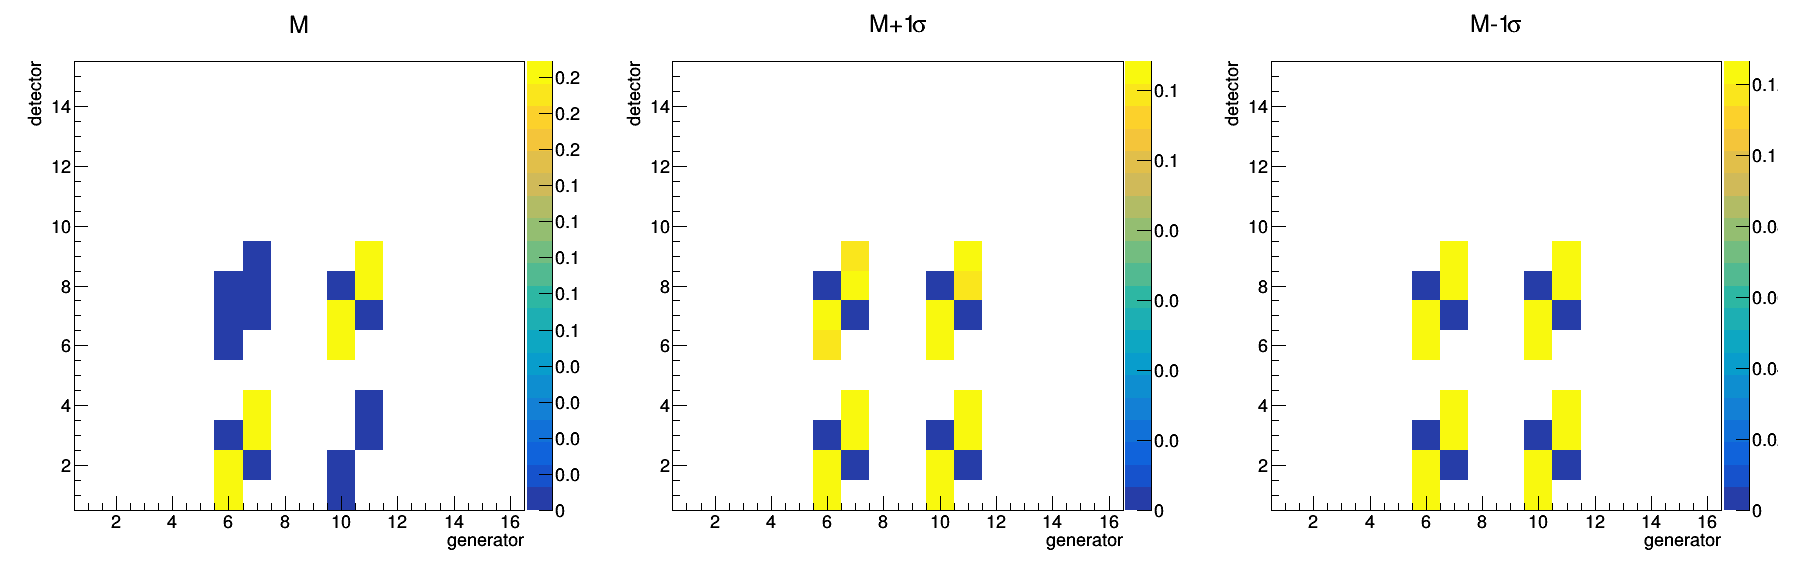

In [15]:

c0 = ROOT.TCanvas("c0", "c0", 1800, 600)
c0.Divide(3,1)
c0.cd(1)
M.Draw("colz")
c0.cd(2)
M1.Draw("colz")
c0.cd(3)
M2.Draw("colz")
c0.Draw()

## Plot the reconstructed and truth

In [16]:
crec1 = ROOT.TCanvas("cr1", "creco", 600, 600)


In [17]:
h2 = M.ProjectionY("reco2")
htrue2 = M.ProjectionX("gen2")


In [18]:
htruef.SetLineColor(2)
h.SetMarkerStyle(20)
h2.SetMarkerStyle(22)

htruef.SetMarkerStyle(21)
htrue.SetMarkerStyle(23)
htrue2.SetMarkerStyle(24)

h.SetMarkerColor(ROOT.kBlue)
h2.SetMarkerColor(ROOT.kMagenta)
htruef.SetMarkerColor(ROOT.kRed)
htrue2.SetMarkerColor(ROOT.kRed)

h.SetLineColor(ROOT.kBlue)
htruef.SetLineColor(ROOT.kRed)
htrue.SetLineColor(ROOT.kBlack)
#htrue.SetLineColor(ROOT.kRed)


In [19]:
#htrue2.Draw("e ")

h.Draw('e same')

#h.SetMinimum(.0)
#h.SetMaximum(25000.)

#h.SetMinimum(.15)
#h.SetMaximum(1.)

h.SetMinimum(.0)
h.SetMaximum(2.)


h2.Draw('e same')

hup.Draw("hist same")
hdn.Draw("hist same")
htruef.Draw("e same")
htrue.Draw("e same")
htrue2.Draw("e same")


In [20]:
leg1 = ROOT.TLegend(0.7,0.7,0.86, 0.86)
leg1.SetBorderSize(0)
leg1.SetFillColor(0)
leg1.AddEntry( h2, 'Reco from M', 'p')
leg1.AddEntry( h, 'Reco', 'p')
leg1.AddEntry( hup, '+1#sigma', 'l')
leg1.AddEntry( hdn, '-1#sigma', 'l')
leg1.AddEntry( htruef, 'True', 'p')
leg1.AddEntry( htrue, 'True Gen Binned', 'p')
leg1.AddEntry( htrue2, 'True from M', 'p')

leg1.Draw()

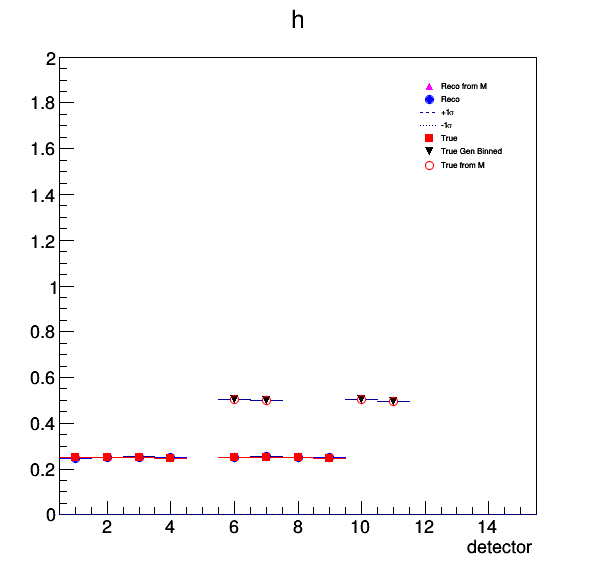

In [21]:
crec1.Draw()

## Unfold

1. Create the `TUnfoldDensity` object. 
1. Add the systematic uncertainty variations via `AddSysError`. 
1. Perform the regularization by scanning the L curve. 
1. Get the output. **Note! This does not account for systematic uncertainties automatically. They must be added by hand.**
1. Draw unfolded versus true distributions (in the same coarse binning scheme). 

In [22]:
orientation = ROOT.TUnfold.kHistMapOutputHoriz
regMode = ROOT.TUnfold.kRegModeCurvature
con = ROOT.TUnfold.kEConstraintNone#Area #ROOT.TUnfold.kEConstraintArea
mode =  ROOT.TUnfoldDensity.kDensityModeNone #BinWidth
axisSteering =  "*[]"

#u = ROOT.TUnfoldDensity(M,orientation,regMode,con)
u = ROOT.TUnfoldDensity(M, orientation, regMode, con, mode, genBin, detBin, "signal", axisSteering)

Info in <TUnfold::SetConstraint>: fConstraint=0
Warning in <TUnfold::TUnfold>: 14 output bins do not depend on the input data  0-5 8-9 12-17
Info in <TUnfold::TUnfold>: 15 input bins and 4 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #1 (signal:ptgen[ufl]:massgen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #2 (signal:ptgen[ufl]:massgen[0,50])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #3 (signal:ptgen[ufl]:massgen[50,100])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #4 (signal:ptgen[ufl]:massgen[ofl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (signal:ptgen[0,50]:massgen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #8 (signal:ptgen[0,50]:massgen[ofl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #9 (signal:ptgen[50,100]:massgen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #12 (signal:ptgen[50,100]:massgen[ofl])


In [23]:
u.SetInput( h )


7

Warning in <TUnfoldDensity::SetInput>: 7/15 input bins have zero error, and are ignored.


In [24]:
u.AddSysError(M1, "Up", orientation, ROOT.TUnfoldDensity.kSysErrModeShift)
u.AddSysError(M2, "Dn", orientation, ROOT.TUnfoldDensity.kSysErrModeShift)
#ROOT.TUnfoldDensity.kSysErrModeRelative)# ROOT.TUnfoldDensity.kSysErrModeShift)


In [25]:
# Regularize
'''
nScan=50
tauMin=0.0
tauMax=0.0
iBest=0

logTauX = ROOT.MakeNullPointer(ROOT.TSpline)
logTauY = ROOT.MakeNullPointer(ROOT.TSpline)
lCurve = ROOT.MakeNullPointer(ROOT.TGraph)
u.ScanLcurve(nScan,tauMin,tauMax,lCurve,logTauX,logTauY)
'''
u.DoUnfold(0.0)

0.02323544155679105

In [26]:
# Get output... DOES NOT CONTAIN SYSTEMATICS. 
#o = u.GetOutput("o")
o = u.GetOutput("unfolded","","signal", "*[b]", False)
 

In [27]:
# Get systematic shifts of output
o_up = u.GetDeltaSysSource("Up", "o_upshift", "M+1#sigma")
o_dn = u.GetDeltaSysSource("Dn", "o_dnshift", "M-1#sigma")
o_up.SetLineStyle(2)
o_dn.SetLineStyle(2)


In [28]:
# Get various covariances
#cov = u.GetEmatrixTotal("cov", "Covariance Matrix")
cov = u.GetEmatrixTotal("ematrix","Covariance Matrix", "signal", "*[]", False)


cov_uncorr = u.GetEmatrixSysUncorr("cov_uncorr", "Covariance Matrix from Uncorrelated Uncertainties", "signal", "*[]", False)
cov_uncorr_data = u.GetEmatrixInput("cov_uncorr_data", "Covariance Matrix from Stat Uncertainties of Input Data", "signal", "*[]", False)


In [29]:

# Now prepare various distributions. 
o_unfunc = o.Clone("o_unc")        # Unfolding and stat unc
o_sys = o.Clone("o_sys")        # Syst uncertainty
o_unctot = o.Clone("o_unctot")  # Total uncertainty
o_sys.SetLineStyle(2)


In [30]:

# Create total uncertainty and sys uncertainty plots. 
# Also fix the uncertainties on the output
for i in xrange( 0, o_up.GetNbinsX() + 1):
    unc_tot = ROOT.TMath.Sqrt( cov.GetBinContent(i,i) )
    o_unctot.SetBinContent(i, unc_tot )    
    o.SetBinError(i, unc_tot )
    
    yup = abs( o_up.GetBinContent(i))
    ydn = abs( o_dn.GetBinContent(i))
    dy = ROOT.TMath.Sqrt( (yup**2 + ydn**2) )
    o_sys.SetBinContent(i, dy )






In [31]:
#htrue2 = htrue.Clone("h2")
#htrue2.Rebin(finebins/coarsebins)
o.SetMarkerStyle(20)
o.SetMarkerColor(1)
o_unfunc.SetMarkerStyle(0)
o_unfunc.SetLineColor(2)
htrue.SetMarkerStyle(21)
htrue.SetMarkerColor(4)
htrue.SetMarkerStyle(4)
htrue.SetLineColor(4)



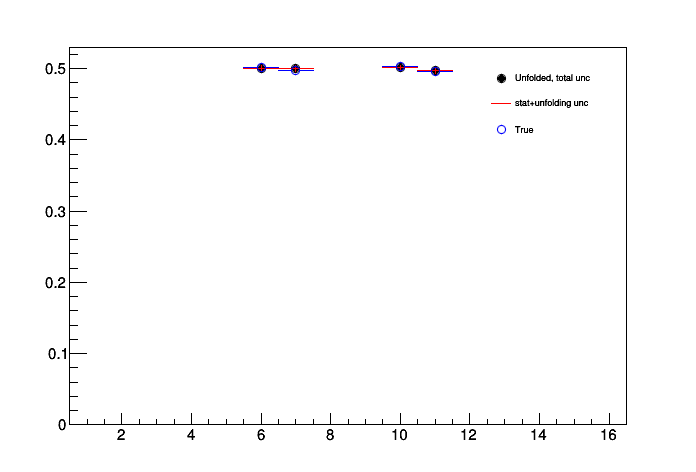

In [32]:
c = ROOT.TCanvas("c","c")
#o.SetMinimum(0.0)
#o.SetMaximum(1.0)

o.Draw()
o_unfunc.Draw("e same")
htrue.Draw("e same")
leg2 = ROOT.TLegend(0.7, 0.7, 0.86, 0.86)
leg2.SetBorderSize(0)
leg2.SetFillColor(0)
leg2.AddEntry( o, "Unfolded, total unc",'p')
leg2.AddEntry( o_unfunc, "stat+unfolding unc",'l')
leg2.AddEntry( htrue, "True",'p')
leg2.Draw()
c.Draw()

## Draw the LCurve. 

In [33]:
#print lCurve
#if lCurve:
#    cl = ROOT.TCanvas("cl", "cl", 500, 500)
#    lCurve.Draw("alp")
#    cl.Draw()

## Plot closure

The closure plot is the true distribution divided by the unfolded distribution. Aside from the outermost bins, the closure is consistent with unity. 

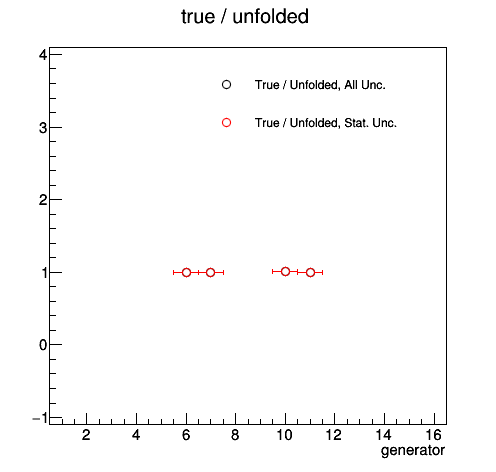

In [34]:
c2 = ROOT.TCanvas("c2", "c2", 500, 500)
closure = htrue.Clone("closure")
closure2 = htrue.Clone("closure2")
closure.SetMarkerColor(1)
closure.SetLineColor(1)
closure2.SetMarkerColor(2)
closure2.SetLineColor(2)
closure.SetTitle("true / unfolded")
closure.Divide(o)
closure2.Divide(o_unfunc)
closure.Draw('e1')
closure2.Draw('e1 same')
closure.SetMaximum(4.1)
closure.SetMinimum(-1.1)

legclosure = ROOT.TLegend(0.4, 0.7, 0.86, 0.86)
legclosure.SetBorderSize(0)
legclosure.SetFillColor(0)
legclosure.AddEntry( closure, "True / Unfolded, All Unc.", 'p')
legclosure.AddEntry( closure2, "True / Unfolded, Stat. Unc.", 'p')
legclosure.Draw()
c2.Draw()

## Plot the total covariance matrix

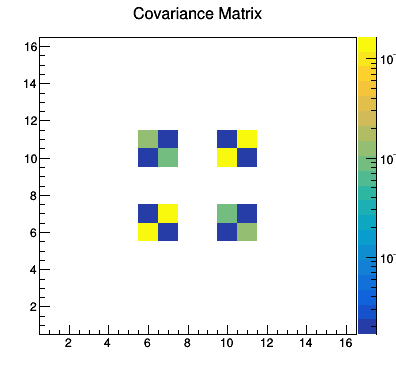

In [35]:

ccov = ROOT.TCanvas("ccov", "Covariance Matrix", 400, 400)
cov.Draw('colz')
ccov.SetLogz()
ccov.Draw()


## Plot the covariance matrix from uncorrelated (stat.) uncertainties

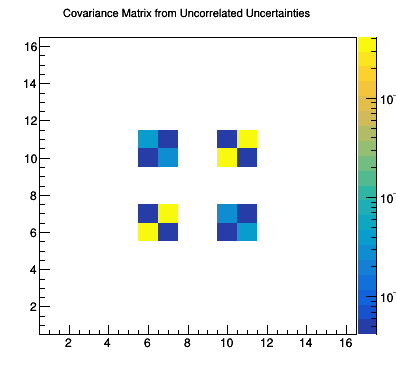

In [36]:

ccov_uncorr = ROOT.TCanvas("ccov_uncorr", "Covariance Matrix from Uncorrelated Uncertainties", 400, 400)
cov_uncorr.Draw('colz')
ccov_uncorr.SetLogz()
ccov_uncorr.Draw()



## Plot covariance matrix of the statistical uncertainties from the input data

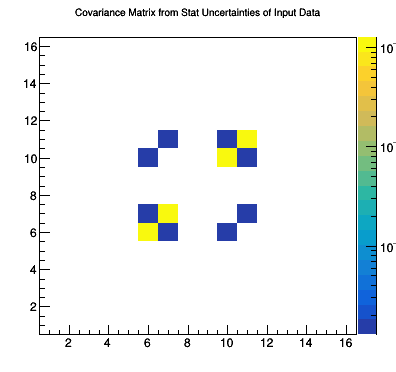

In [37]:

ccov_uncorr_data = ROOT.TCanvas("ccov_uncorr_data", "Covariance Matrix from Uncorrelated Uncertainties", 400, 400)
cov_uncorr_data.Draw('colz')
ccov_uncorr_data.SetLogz()
ccov_uncorr_data.Draw()



## Plot absolute uncertainties



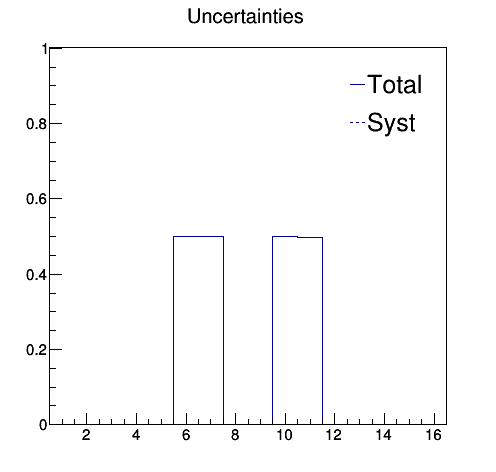

In [38]:

#
unc_stack = ROOT.THStack("unc_stack", "Uncertainties")
unc_stack.Add( o_unctot, "hist" )
unc_stack.Add( o_sys, "hist" )
#o_up.Divide(o)
#o_dn.Divide(o)



c_sys = ROOT.TCanvas("c_sys", "c_sys", 500, 500)
unc_stack.Draw("nostack")
unc_stack.SetMaximum( 1.0 * unc_stack.GetMaximum() )
#o_unc.SetMinimum(-0.2)
#o_unc.SetMaximum(+0.2)
legsys = ROOT.TLegend(0.7, 0.7, 0.86, 0.86)
legsys.SetFillColor(0)
legsys.SetBorderSize(0)
legsys.AddEntry( o_unctot, 'Total', 'l')
legsys.AddEntry( o_sys, 'Syst', 'l')
legsys.Draw()
c_sys.Draw()